# DEM model local run


In [1]:
#papermill_description=imports

import json
import os
import geopandas as gpd
import shapely
from io import StringIO
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from gis_utils.stac import initialize_stac_client, query_stac_api, save_metadata_sidecar, process_dem_asset_and_mask
from gis_utils.dataframe import get_bbox_from_geodf
import rasterio.plot
import logging
import sys
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from rasterio.io import MemoryFile
from matplotlib import cm
from matplotlib.colors import Normalize
from rasterio.plot import reshape_as_raster
from gis_utils.colormap import get_colormap, display_colormap_as_html
from rasterio.warp import calculate_default_transform

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
#papermill_description=compute_elevation_statistics

def compute_elevation_statistics(dem_data):
    """
    Compute basic elevation statistics from a digital elevation model (DEM) dataset.

    This function calculates the minimum, maximum, mean, and standard deviation of elevation
    values within the provided DEM data array. It handles the DEM data as a NumPy array,
    which is a common format for raster data in Python.

    Parameters:
    - dem_data (numpy.ndarray): A 2D NumPy array containing elevation data from a DEM raster.
      The array should contain numeric values representing elevation at each cell. No-data
      values should be represented by NaNs in the array to be properly ignored in calculations.

    Returns:
    - dict: A dictionary containing the computed elevation statistics, with keys 'min_elevation',
      'max_elevation', 'mean_elevation', and 'std_dev_elevation'.
    """

    # Compute the minimum elevation, ignoring any NaN values which represent no-data cells
    min_elevation = float(np.nanmin(dem_data))

    # Compute the maximum elevation, ignoring any NaN values
    max_elevation = float(np.nanmax(dem_data))

    # Compute the mean elevation, ignoring any NaN values
    mean_elevation = float(np.nanmean(dem_data))

    # Compute the standard deviation of elevation, ignoring any NaN values
    std_dev_elevation = float(np.nanstd(dem_data))

    # Construct and return a dictionary containing the computed statistics
    stats = {
        'min_elevation': min_elevation,
        'max_elevation': max_elevation,
        'mean_elevation': mean_elevation,
        'std_dev_elevation': std_dev_elevation
    }

    return stats

In [3]:
#papermill_description=parameters

notebook_key = "localjupyter"
propertyName = "test"
output_type = "overlay"
colormap = "gist_earth"
si_unit = "metres above sea level"
si_unit_short = "m"


<Axes: >

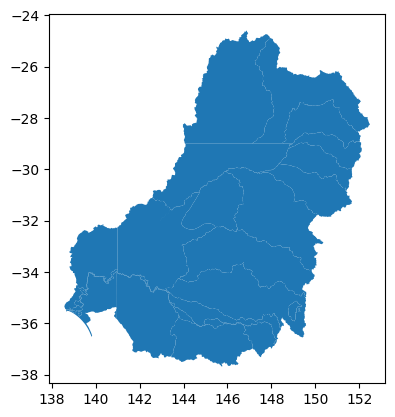

In [4]:
geojson = gpd.read_file("/workspace/notebooks/sandbox/data/input-data/onebasin/Surface Water Water Resource Plan Areas/Surface Water Water Resource Plan Areas.shp")

geojson.plot()

In [5]:
#papermill_description=process_variables

elevation_json_filename = "/workspace/notebooks/sandbox/data/output-data/onebasin/dem_onebasin_elevation-stats.json"
output_tiff_filename = "/workspace/notebooks/sandbox/data/output-data/onebasin/dem_onebasin_test.tiff"

output_colored_tiff_filename = "/workspace/notebooks/sandbox/data/output-data/onebasin/dem_colored_onebasin_test.tiff"
output_cog_filename = "/workspace/notebooks/sandbox/data/output-data/onebasin/dem_cog_onebasin_test.public.tiff"

In [6]:
#papermill_description=processing_bounding_box

# Get bounding box from GeoJSON
bbox = geojson.total_bounds

# Get polygon coordinates in rasterio-friendly format. Equivalent to a shapely polygon.
coords = geojson.geometry.values

In [7]:
#papermill_description=processing_stac_init

#Jenna has commented out the RGB stac items because this notebook is only for processing and returning a dem. So the RGB stac items are not needed and it might speed the execution up.

stac_url_dem = "https://explorer.sandbox.dea.ga.gov.au/stac/"
collections_dem = ['ga_srtm_dem1sv1_0']

# Initialize STAC clients
print(f"Initializing STAC client for DEM with URL: {stac_url_dem} and collections: {collections_dem}")
client_dem = initialize_stac_client(stac_url_dem)

Initializing STAC client for DEM with URL: https://explorer.sandbox.dea.ga.gov.au/stac/ and collections: ['ga_srtm_dem1sv1_0']
Initializing STAC client for URL: https://explorer.sandbox.dea.ga.gov.au/stac/
STAC client initialized successfully


In [8]:
#papermill_description=processing_stac_search

# Query STAC catalogs
items_dem = query_stac_api(client_dem, bbox, collections_dem, None, None) #modified the query_stac_api function to accept polygon + bbox for masking

Found 1 items


In [9]:
#papermill_description=processing_stac_assets

# Only want the dem asset
item = items_dem[0]
dem_asset = item.assets.get('dem')
fallback_dem = {
		'title': 'dem',
		'href': 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'
}
primary_dem = dem_asset if dem_asset else fallback_dem

In [10]:
# with rasterio.open(dem_asset.href) as src:
#     # Nodata value here is being set to 0. This works for DEM but is not OK for indices.
#     data, out_transform = rasterio.mask.mask(src, coords, crop=True, nodata=np.nan)

In [11]:
#papermill_description=processing_dem_asset

# Modified function including mask/clip:
data, metadata, src = process_dem_asset_and_mask(primary_dem, coords, bbox, output_tiff_filename)

Opening DEM asset from: s3://dea-public-data/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif
Writing to file: /workspace/notebooks/sandbox/data/output-data/onebasin/dem_onebasin_test.tiff
Written masked data to /workspace/notebooks/sandbox/data/output-data/onebasin/dem_onebasin_test.tiff
Output mask file size: 9451866280 bytes


In [12]:
#papermill_description=processing

""" 
This is now broken because the masked data contains nodata values. 
Need to contain the stats calculations to within clipped area so only valid values are passed in
"""
elevation_stats = compute_elevation_statistics(data)

# Serialize 'elevation_stats' to a JSON string
elevation_stats_json = json.dumps(elevation_stats)
# Convert the JSON string to bytes
elevation_stats_bytes = elevation_stats_json.encode()

# asset_type signifies the type of asset, e.g. overlay that is stored in the application DB
asset_metadata = {
    'properties': {
        'output_type': output_type,
        'si_unit': si_unit,
        'si_unit_short': si_unit_short,
        'name': 'DEM',
    },
    'data': {
        'elevation_stats': elevation_stats,
    },
}

: 

In [13]:
#papermill_description=processing_cog

with rasterio.open(output_tiff_filename) as mew:
    meta = mew.meta.copy()
    dst_crs = rasterio.crs.CRS.from_epsg(4326)
    transform, width, height = calculate_default_transform(
        mew.crs, dst_crs, mew.width, mew.height, *mew.bounds
    )

    meta.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    tif_data = mew.read(1, masked=True).astype('float32') #setting masked=True here tells rasterio to use masking information if present, but we need to add the mask itself first.
    mew_formatted = tif_data.filled(np.nan)

    cmap = cm.get_cmap(colormap) #can also use 'terrain' cmap to keep this the same as the preview image from above.
    na = mew_formatted[~np.isnan(mew_formatted)]

    min_value = min(na)
    max_value = max(na)

    norm = Normalize(vmin=min_value, vmax=max_value)

    coloured_data = (cmap(norm(mew_formatted))[:, :, :3] * 255).astype(np.uint8)

    meta.update({"count":3})


    with rasterio.open(output_colored_tiff_filename, 'w', **meta) as dst:
        reshape = reshape_as_raster(coloured_data)
        dst.write(reshape)

try:
    dst_profile = cog_profiles.get('deflate')
    with MemoryFile() as mem_dst:
        cog_translate(
            output_colored_tiff_filename,
            output_cog_filename,
            config=dst_profile,
            in_memory=True,
            dtype="uint8",
            add_mask=False,
            nodata=0,
            dst_kwargs=dst_profile
        )
    
    save_metadata_sidecar(output_cog_filename, asset_metadata)    
except:
    raise Exception('Unable to convert to cog')

/tmp/ipykernel_6199/2656408351.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap) #can also use 'terrain' cmap to keep this the same as the preview image from above.


In [ ]:
#papermill_description=legends

colormap_legend = get_colormap(colormap, [elevation_stats['min_elevation'], elevation_stats['mean_elevation'],  elevation_stats['max_elevation']], 21)

display_colormap_as_html(colormap_legend)

asset_metadata['legend'] = {
	'colormap': {
		'type': 'discrete',
		'colors': colormap_legend
	},
	'unit': si_unit_short
}

In [ ]:
#papermill_description=plotly_graphing

with rasterio.open(output_tiff_filename) as src:
    elevation = src.read(1)  # Read the first band
    print("Dataset shape:", elevation.shape)


num_rows = elevation.shape[0]

# Ensure the row index is valid
# For example, use the middle row of the dataset
row_index = num_rows // 2  # This guarantees a valid index within the data's bounds

# Extract the elevation data for that row
horizontal_line = elevation[row_index, :]

# Apply additional characteristics to notebook artefacts
asset_metadata['properties']['platform'] = 'Space Shuttle Endeavour'
asset_metadata['properties']['overlayType'] = 'DEM'

save_metadata_sidecar(output_cog_filename, asset_metadata)
